In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from data_loader import PybulletNpyDataset, TabletopTemplateDataset

In [2]:
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/train'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-seen_template'
#data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-seen_obj-unseen_template'
data_path = '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-unseen_template'
dataset = TabletopTemplateDataset(data_dir=data_path, 
            remove_bg=True, label_type='linspace', view='top')

In [35]:
os.listdir(os.path.join(data_path, 'D8', 'template_00012', 'traj_0020'))

FileNotFoundError: [Errno 2] No such file or directory: '/ssd/disk/TableTidyingUp/dataset_template/test-unseen_obj-unseen_template/D8/template_00012/traj_0020'

In [3]:
import torch
import clip

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device=device)
# model, preprocess = clip.load("ViT-L/14", device=device)
# model, preprocess = clip.load("ViT-B/32", device=device)

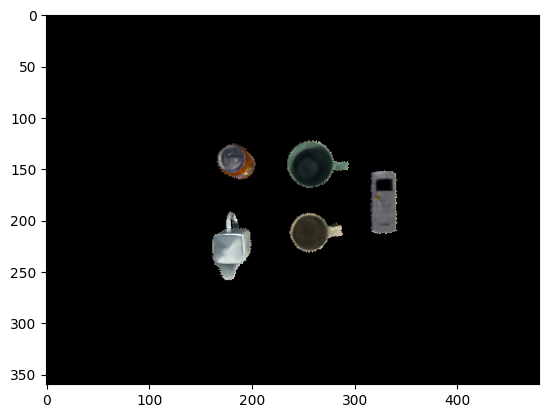

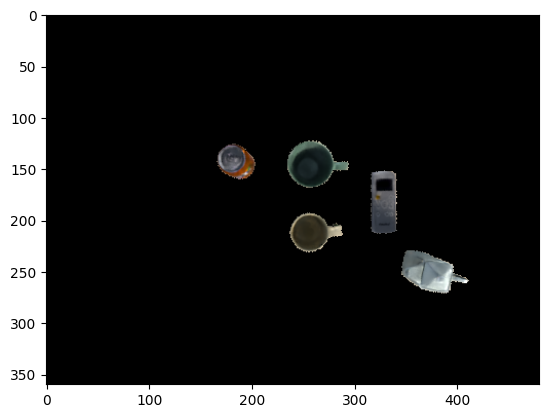

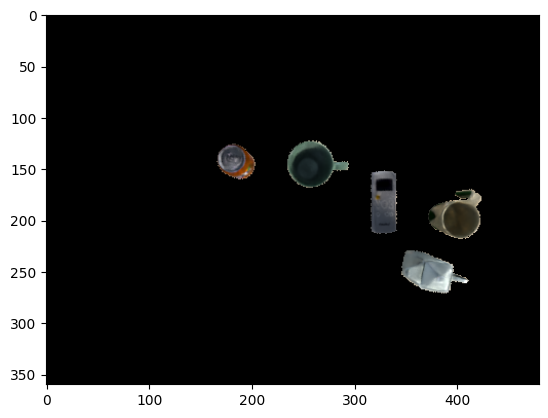

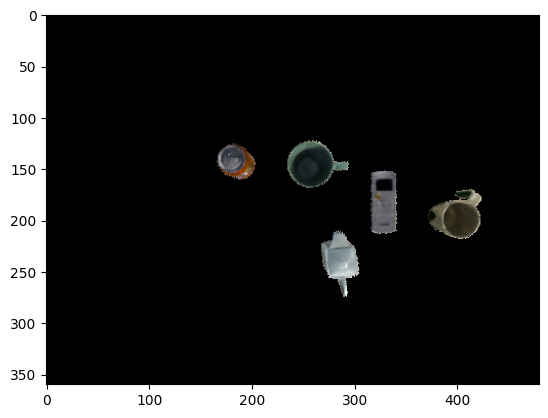

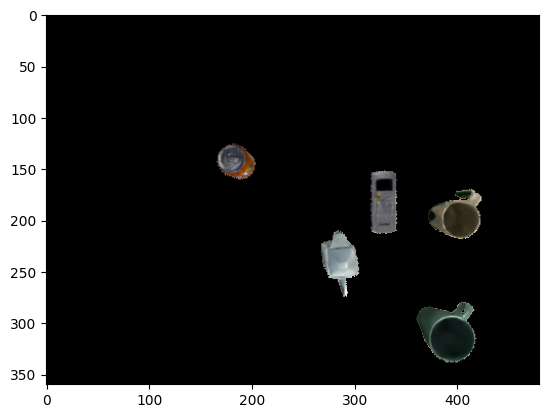

In [6]:
rgbs = []
indices = [2000, 2001, 2002, 2003, 2004]
for i in indices:
    rgb = np.array(Image.open(dataset.data_paths[i] + '/rgb_top.png'))[:, :, :3]
    mask = np.load(dataset.data_paths[i] + '/seg_top.npy')
    rgb = rgb * (mask!=mask.max())[:, :, None]
    rgbs.append(rgb)
    plt.imshow(rgb)
    plt.show()

In [25]:
images = []
for rgb in rgbs:
    image = preprocess(Image.fromarray(rgb)).unsqueeze(0).to(device)
    images.append(image)
images = torch.cat(images, 0)

In [22]:
text = clip.tokenize(["line shape"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(images, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print("Label logits:", logits_per_text)# logits_per_image)
print("Prob:", probs)

Label logits: tensor([[15.2969, 16.2344, 16.5000, 16.1406, 15.5547]], device='cuda:0',
       dtype=torch.float16)
Prob: [[0.0952 0.2432 0.3171 0.2213 0.1232]]


In [27]:
(image_features/image_features.norm(dim=-1, keepdim=True)) @ (text_features/text_features.norm(dim=-1, keepdim=True)).T

tensor([[0.1614, 0.1432, 0.1530, 0.1694, 0.1642],
        [0.1615, 0.1495, 0.1624, 0.1799, 0.1696],
        [0.1578, 0.1459, 0.1649, 0.1766, 0.1644],
        [0.1470, 0.1390, 0.1614, 0.1691, 0.1606],
        [0.1445, 0.1371, 0.1555, 0.1729, 0.1638]], device='cuda:0',
       dtype=torch.float16)

In [26]:
text = clip.tokenize(["regular", "straight", "line shape", "tidy table", "organized table"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(images, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print("Label logits:", logits_per_text)# logits_per_image)
print("Prob:", probs)

Label logits: tensor([[16.1406, 16.1406, 15.7812, 14.6953, 14.4531],
        [14.3203, 14.9453, 14.5781, 13.8984, 13.7031],
        [15.2969, 16.2344, 16.5000, 16.1406, 15.5547],
        [16.9375, 17.9844, 17.6562, 16.9062, 17.2812],
        [16.4062, 16.9531, 16.4375, 16.0625, 16.3750]], device='cuda:0',
       dtype=torch.float16)
Prob: [[0.3206  0.3206  0.2239  0.07556 0.05933]
 [0.1866  0.3486  0.2416  0.12244 0.1007 ]
 [0.0952  0.2432  0.3171  0.2213  0.1232 ]
 [0.1208  0.344   0.2478  0.11707 0.1703 ]
 [0.1838  0.3176  0.1897  0.1304  0.1782 ]]


In [24]:
images = []
for rgb in rgbs:
    image = preprocess(Image.fromarray(rgb.astype(bool).astype(np.uint8)*255)).unsqueeze(0).to(device)
    images.append(image)
images = torch.cat(images, 0)

In [19]:
text = clip.tokenize(["regular", "straight", "line shape", "tidy table", "organized table"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(images, text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print("Label logits:", logits_per_text)# logits_per_image)
print("Prob:", probs)

Label logits: tensor([[17.2969, 17.7812, 17.0938, 16.9688, 18.2188],
        [14.8359, 15.8125, 15.2109, 14.9375, 15.8438],
        [20.4375, 20.6250, 21.6250, 20.9219, 21.6250],
        [15.9297, 16.8281, 17.6875, 16.6406, 19.0000],
        [16.5938, 17.4688, 18.4688, 17.5625, 19.1875]], device='cuda:0',
       dtype=torch.float16)
Prob: [[0.1499  0.2432  0.1223  0.1079  0.3767 ]
 [0.11163 0.2964  0.1625  0.1236  0.306  ]
 [0.09625 0.11615 0.3157  0.1562  0.3157 ]
 [0.03046 0.07477 0.1766  0.06198 0.6562 ]
 [0.03857 0.09247 0.2515  0.10156 0.516  ]]


In [20]:
(image_features/image_features.norm(dim=-1, keepdim=True)) @ (text_features/text_features.norm(dim=-1, keepdim=True)).T

tensor([[0.1730, 0.1483, 0.2043, 0.1593, 0.1659],
        [0.1779, 0.1581, 0.2063, 0.1682, 0.1747],
        [0.1709, 0.1521, 0.2162, 0.1769, 0.1847],
        [0.1697, 0.1494, 0.2094, 0.1664, 0.1755],
        [0.1823, 0.1584, 0.2163, 0.1899, 0.1919]], device='cuda:0',
       dtype=torch.float16)

In [14]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7f9b88f78280>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [164]:
dir(clip)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'available_models',
 'clip',
 'load',
 'model',
 'simple_tokenizer',
 'tokenize']

In [166]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [128]:
logits_per_text

tensor([[22.4219],
        [25.6094],
        [24.2031],
        [22.1094],
        [24.7500],
        [25.3438],
        [24.2500]], device='cuda:0', dtype=torch.float16)

In [101]:
logits_per_image

tensor([[22.4688, 26.3594, 24.7500, 20.6562, 24.7969, 26.4531, 24.1875]],
       device='cuda:0', dtype=torch.float16)

In [103]:
image_features.shape

torch.Size([1, 512])

In [105]:
text_features.shape

torch.Size([7, 512])

In [107]:
torch.matmul(image_features, text_features.T)

tensor([[25.2344, 29.8125, 27.5938, 22.3438, 28.3281, 29.1562, 26.7188]],
       device='cuda:0', dtype=torch.float16)